In [2]:
import numpy as np
import csv
import scipy as sp
import matplotlib.pyplot as plt
import scipy.interpolate
import random

In [3]:
lon = []
lat = []
elev = []
with open('processed_welldata.csv', newline='') as csvf:
    spamreader = csv.reader(csvf, delimiter=',')
    for i, row in enumerate(spamreader):
        if i == 0:
            continue
        lat.append(float(row[1]))
        lon.append(float(row[2]))
        elev.append(float(row[3]))

        

In [4]:
len(lat)

79053

In [5]:
len(np.unique(lat))
len(np.unique(lon))

67525

## Extract points in Kendall county

In [7]:
corners_champaign = [(40.398855, -88.459827), (39.880882, -87.939255)]
corners_kendall = [(41.720347, -88.603715), (41.463580, -88.252839)]

def extract_county(lat, lon, corners):
    idx = []
    for i in range(len(lat)):
        if lat[i] >= corners[1][0] and corners[0][0] >= lat[i]:
            if lon[i] >= corners[0][1] and corners[1][1] >= lon[i]:
                idx.append(i)
    return idx

In [7]:
idx_kendall = extract_county(lat, lon, corners_kendall)

In [8]:
len(idx_kendall)

1856

## Run interpolation for Kendall County

In [9]:
lat_kendall = np.array([lat[i] for i in idx_kendall])
lon_kendall = np.array([lon[i] for i in idx_kendall])
elev_kendall = np.array([elev[i] for i in idx_kendall])
# Default parameters: functions=thin_plate, smooth=3, epsilon=5
spline_kendall = sp.interpolate.Rbf(lat_kendall, lon_kendall, elev_kendall,
                                    function='multiquadric',smooth=3, episilon=5)

## Check residuals for outliers

In [10]:
residual_kendall = np.subtract(elev_kendall, spline_kendall(lat_kendall, lon_kendall))

In [11]:
len(residual_kendall)

1856

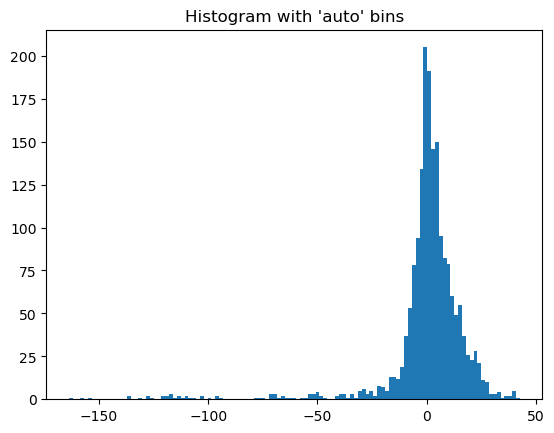

In [12]:
_ = plt.hist(residual_kendall, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [13]:
outliers = [i for i in range(len(residual_kendall)) if abs(residual_kendall[i]) >= 50]

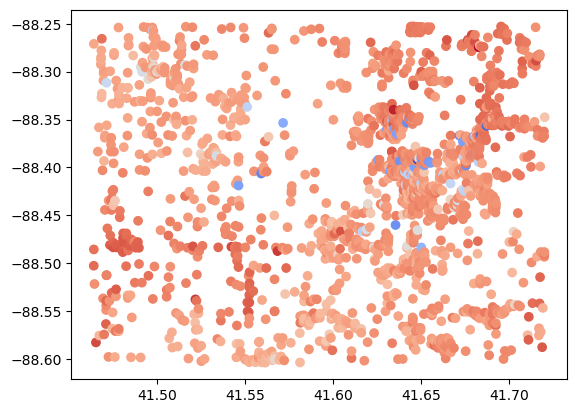

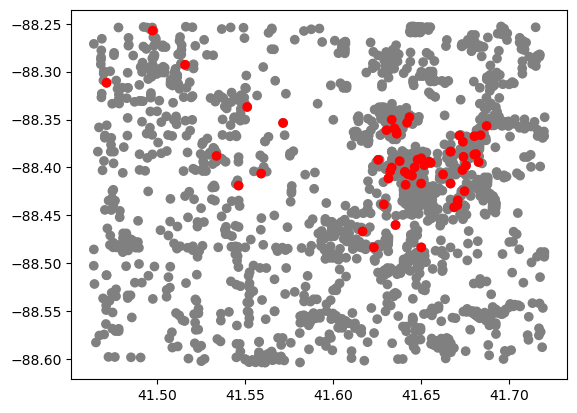

In [14]:
plt.scatter(lat_kendall, lon_kendall, c=elev_kendall, cmap='coolwarm')
plt.show()
plt.scatter(list(lat_kendall)+[lat_kendall[i] for i in outliers],
            list(lon_kendall)+[lon_kendall[i] for i in outliers],
            c = ['gray']*len(lon_kendall)+['red']*len(outliers))
plt.show()


# Test for 10,000 points

In [8]:
corners_enlarge = [(41.720347+0.2, -88.603715-0.2), (41.463580-0.2, -88.252839+0.2)]
corners_kendall = [(41.720347, -88.603715), (41.463580, -88.252839)]

In [9]:
idx_enlarge = extract_county(lat, lon, corners_enlarge)

In [10]:
len(idx_enlarge)

12346

In [11]:
lat_enlarge = np.array([lat[i] for i in idx_enlarge])
lon_enlarge = np.array([lon[i] for i in idx_enlarge])
elev_enlarge = np.array([elev[i] for i in idx_enlarge])
# Default parameters: functions=thin_plate, smooth=3, epsilon=5
spline_enlarge = sp.interpolate.Rbf(lat_enlarge, lon_enlarge, elev_enlarge,
                                    function='multiquadric',smooth=4, episilon=5)

In [12]:
residual_enlarge = np.subtract(elev_enlarge, spline_enlarge(lat_enlarge, lon_enlarge))

In [13]:
len(residual_enlarge)

12346

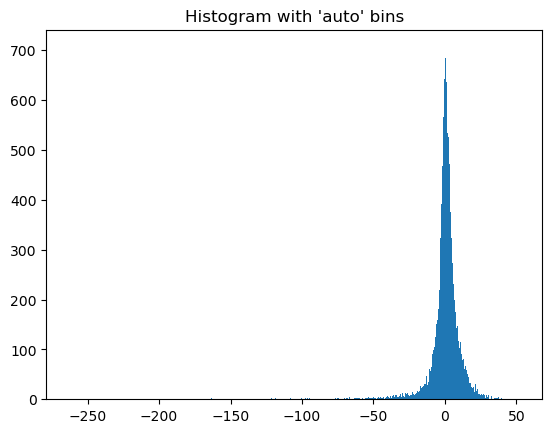

In [14]:
#_ = plt.hist([residual_enlarge[i] for i in range(len(residual_enlarge)) if abs(residual_enlarge[i]) <= 50], bins='auto')
_ = plt.hist(residual_enlarge, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()


In [17]:
std = np.std(residual_enlarge)

In [21]:
outliers_enlarge = [i for i in range(len(residual_enlarge)) if abs(residual_enlarge[i]) >= 3*std]

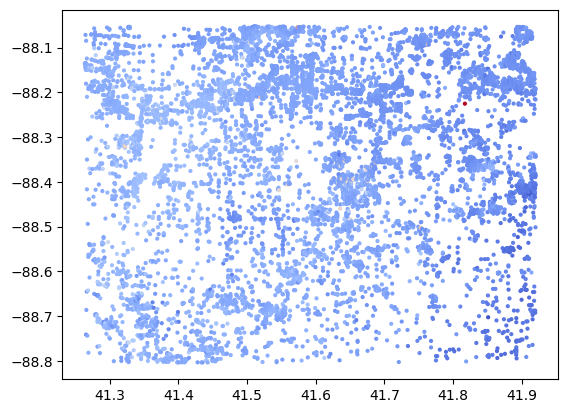

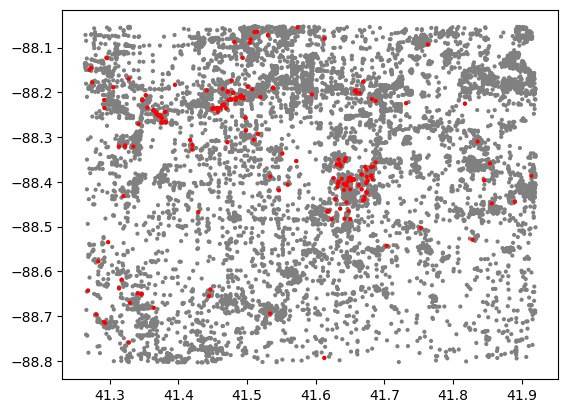

In [22]:
plt.scatter(lat_enlarge, lon_enlarge, c=elev_enlarge, cmap='coolwarm_r',s=4)
plt.show()
plt.scatter(list(lat_enlarge)+[lat_enlarge[i] for i in outliers_enlarge],
            list(lon_enlarge)+[lon_enlarge[i] for i in outliers_enlarge],
            c = ['gray']*len(lon_enlarge)+['red']*len(outliers_enlarge), s=4)
plt.show()

In [82]:
scipy.stats.normaltest(residual_enlarge)

NormaltestResult(statistic=13185.732846095012, pvalue=0.0)

In [69]:
scipy.stats.normaltest([residual_enlarge[i] for i in range(len(residual_enlarge)) if abs(residual_enlarge[i]) <= 5 ])

NormaltestResult(statistic=517.0298091828708, pvalue=5.350611839496533e-113)

In [62]:
scipy.stats.kurtosistest(residual_enlarge)

KurtosistestResult(statistic=64.87082114788582, pvalue=0.0)

In [63]:
scipy.stats.skewtest(residual_enlarge)

SkewtestResult(statistic=-94.7497198396598, pvalue=0.0)

In [81]:
rng = np.random.default_rng()
pts = 1000
a = rng.normal(0, 1, size=pts)
scipy.stats.normaltest(a)

NormaltestResult(statistic=1.11425851437626, pvalue=0.5728512141307236)

In [96]:
import pylab
scipy.stats.probplot([residual_enlarge[i] for i in range(len(residual_enlarge)) if abs(residual_enlarge[i]) <= 50 ], 
                     dist='norm', plot=pylab)

((array([-3.8597026 , -3.63725138, -3.5152472 , ...,  3.5152472 ,
          3.63725138,  3.8597026 ]),
  array([-49.99434398, -49.86990356, -49.45700986, ...,  46.45229887,
          47.97446778,  49.94073485])),
 (8.377246550317343, 0.9456992265271246, 0.9451411023279737))

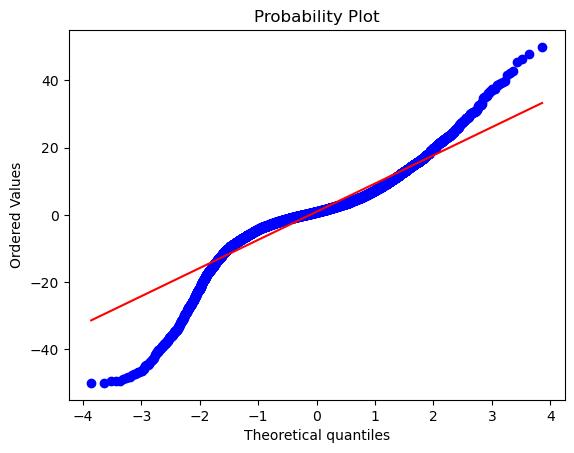

In [97]:
pylab.show()

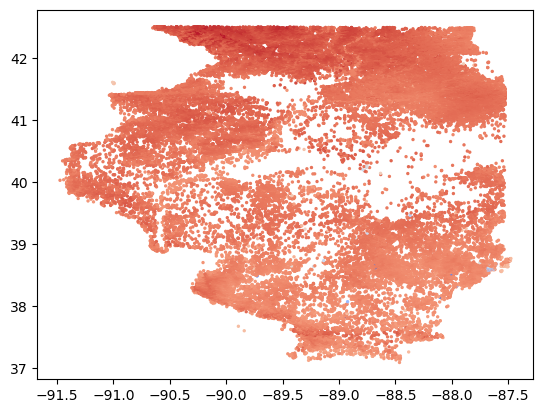

In [27]:
plt.scatter(lon, lat, c=elev, cmap='coolwarm',s=2)
plt.show()

# Interpolate by blocks

In [93]:
def cut_by_latlon(lat, lon, lats, lons):
    res = {}
    cutlines = sorted(lats, reverse=True)
    for i, cutline in enumerate(cutlines):
        if i == 0:
            idx1 = [j for j in range(len(lat)) if (lat[j] >= cutline and lon[j] <= lons[0])]
            idx2 = [j for j in range(len(lat)) if (lat[j] >= cutline and lon[j] > lons[0])]
            res[f'[{cutline},)'] = {'west':idx1, 'east':idx2}
            continue
        idx1 = [j for j in range(len(lat)) if (lat[j] >= cutline and lat[j] < cutlines[i-1] and lon[j] <= lons[i])]
        idx2 = [j for j in range(len(lat)) if (lat[j] >= cutline and lat[j] < cutlines[i-1] and lon[j] > lons[i])]
        res[f'[{cutline}, {cutlines[i-1]})'] = {'west':idx1, 'east':idx2}
        if i == len(lats) - 1:
            idx1 = [j for j in range(len(lat)) if (lat[j] < cutline and lon[j] <= lons[-1])]
            idx2 = [j for j in range(len(lat)) if (lat[j] < cutline and lon[j] > lons[-1])]
            res[f'[, {cutline})'] = {'west':idx1, 'east':idx2}
            
    return res

In [94]:
regions = cut_by_latlon(lat, lon, [41.7,41], [-88.7,-88.1,-89.5])

In [95]:
[len(lst) for v in regions.values() for lst in v.values()]

[13866, 13941, 12719, 13597, 13306, 11624]

In [100]:
def OutlierDetector(lat, lon, elev, data_index):
    lat_region = np.array([lat[i] for i in data_index])
    lon_region = np.array([lon[i] for i in data_index])
    elev_region = np.array([elev[i] for i in data_index])
    # Default parameters: functions=thin_plate, smooth=3, epsilon=5
    spline_region = sp.interpolate.Rbf(lat_region, lon_region, elev_region,
                                    function='multiquadric',smooth=4, episilon=5)
    residual_region = np.subtract(elev_region, spline_region(lat_region, lon_region))

    _ = plt.hist(residual_region, bins='auto')  # arguments are passed to np.histogram
    plt.title("Histogram with 'auto' bins")
    plt.show()

    std_residual = np.std(residual_region)

    outliers_region = [i for i in range(len(residual_region)) if abs(residual_region[i]) >= 3*std_residual]

    plt.scatter(lon_region, lat_region, c=elev_region, cmap='coolwarm_r',s=3)
    plt.show()
    plt.scatter(list(lon_region)+[lon_region[i] for i in outliers_region],
                list(lat_region)+[lat_region[i] for i in outliers_region],
                c = ['gray']*len(lon_region)+['red']*len(outliers_region), s=3)
    plt.show()

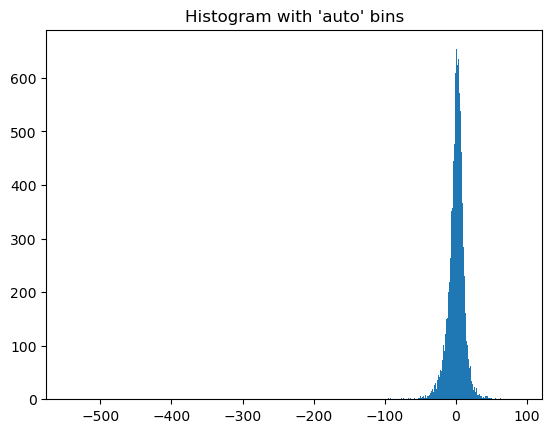

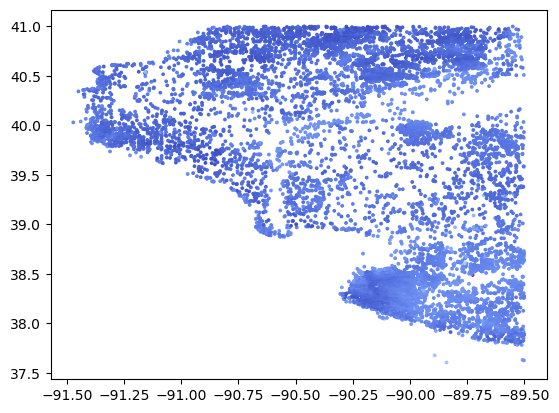

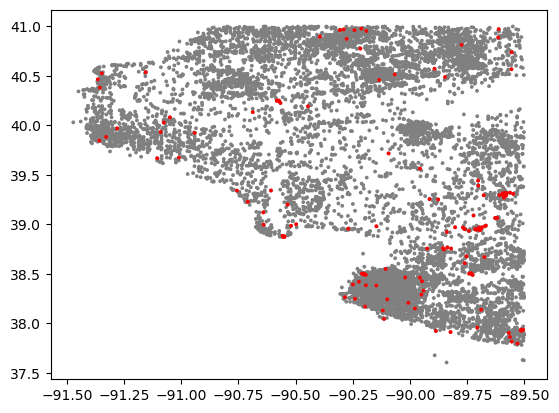

In [101]:
OutlierDetector(lat, lon, elev, regions['[, 41)']['west'])

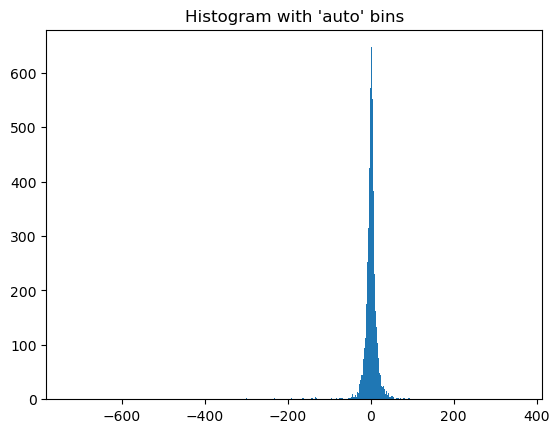

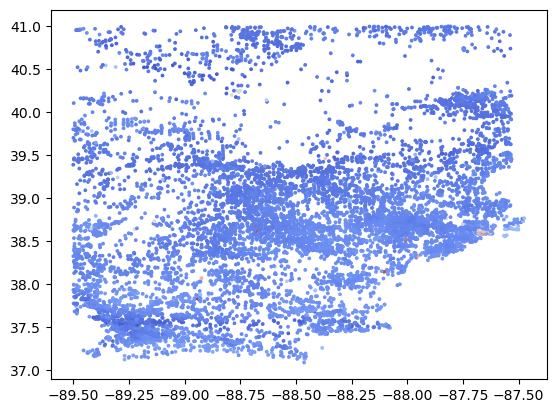

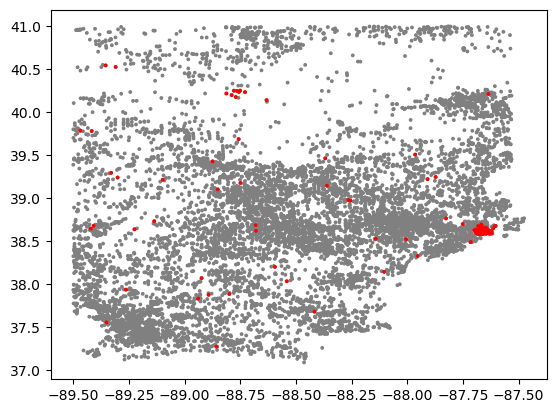

In [102]:
OutlierDetector(lat, lon, elev, regions['[, 41)']['east'])

In [ ]:
OutlierDetector(lat, lon, elev, regions['[41, 41.7)']['west'])
OutlierDetector(lat, lon, elev, regions['[41, 41.7)']['east'])

In [ ]:
OutlierDetector(lat, lon, elev, regions['[41.7,)']['west'])
OutlierDetector(lat, lon, elev, regions['[41.7,)']['east'])